In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd


from src import numbastackelberg as stack
from src import helperfunctions as hf

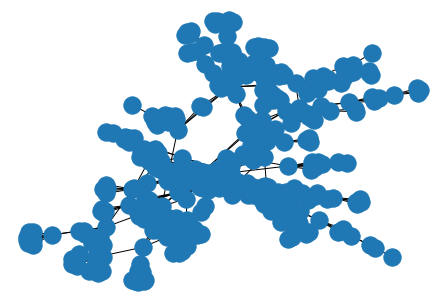

In [2]:
path = '/Users/Work/Documents/GitHub/Master-Thesis/ca-netscience.txt'


df = pd.read_csv(path, delimiter = " ")



def extract_network(df):

    G = nx.from_pandas_edgelist(df,source='FromNodeId', target='ToNodeId')
    subgraphs=[G.subgraph(c) for c in nx.connected_components(G)]
    subgraphs_sizes = sorted([len(subgraph.nodes) for subgraph in subgraphs])
    
    mapping = {i:k for k,i in enumerate(list(G.nodes))}
    H=nx.relabel_nodes(G,mapping)
    
    return H


G = extract_network(df)

nx.draw(G)





In [3]:

def init_allocation(budget_pos,budget_neg):
    pos_share_tight = np.random.uniform(0,1)
    neg_share_tight=np.random.uniform(0,1)

    a_pos = np.random.dirichlet(np.ones(50))*pos_share_tight*budget_pos 
    b_pos =np.random.dirichlet(np.ones(50))*(1.0-pos_share_tight)*budget_pos 

    init_pos = np.concatenate([a_pos,b_pos])

    a_neg = np.random.dirichlet(np.ones(50))*neg_share_tight*budget_neg
    b_neg =np.random.dirichlet(np.ones(50))*(1.0-neg_share_tight)*budget_neg 

    init_neg =  np.concatenate([a_neg,b_neg])

    init_alloc = np.column_stack([init_pos,init_neg]).T
    return init_alloc



In [4]:
def crit_b(graph):
    J = nx.to_numpy_matrix(graph).astype(np.float64)
    eigenvalues,_ = np.linalg.eig(J)
    return 1./np.max(np.abs(eigenvalues))



X = dict.fromkeys([0,1],None)
Y= dict.fromkeys([0,1],None)


beta_crit = crit_b(G)
print(beta_crit)

 
def average_degree(system,control,budget):
    return np.sum([system.graph.degree[i]*con for i,con in enumerate(control)])/budget


0.09638128159431797


In [10]:
b = np.zeros(len(G.nodes.keys()))
budget_pos=40.0
budget_neg=40.0


system = stack.mf_ising_system(G,b,iim_iter=50000,iim_tol_fac=1e-3)

beta=beta_crit/10.0

iters=5
pos_degrees=[]
neg_degrees=[]

centrals = centrality(system)
for i in range(iters):
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta,'random')
#     if system.converged==False:
#         continue
    controls_pos = system.control_field_history_pos
    controls_neg = system.control_field_history_neg
    temp_pos=[]
    temp_neg=[]
    for idx in range(controls_pos.shape[0]):
        pos_degree = average_degree(system,controls_pos[idx],budget_pos)
        neg_degree = average_degree(system,controls_neg[idx],budget_neg)
        temp_pos.append(pos_degree)
        temp_neg.append(neg_degree)
    
    pos_degrees.append(temp_pos)
    neg_degrees.append(temp_neg)




  3%|▎         | 1596/50000 [00:23<11:44, 68.75it/s]


In [11]:
if beta==beta_crit/10.0:
    X[0]=pos_degrees
    Y[0]=neg_degrees
if beta==beta_crit*10.0:
    X[1]=pos_degrees
    Y[1]=neg_degrees
       

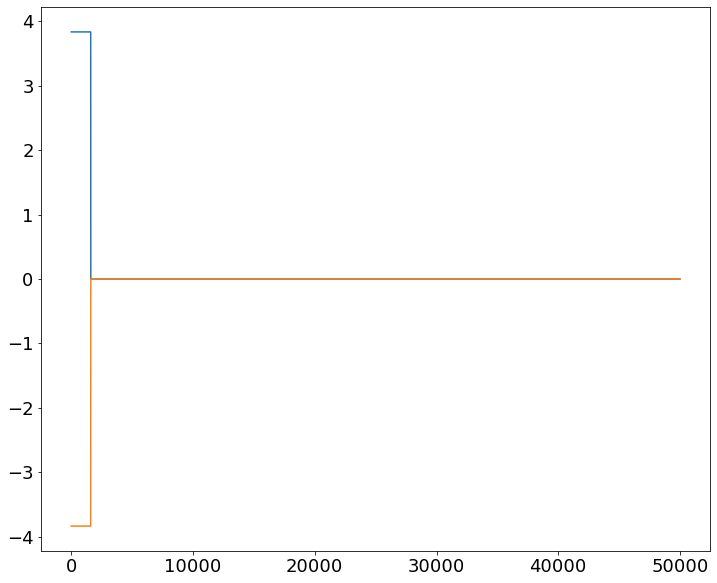

In [12]:
s=np.array(system.pos_gradient_history)

v=np.array(system.neg_gradient_history)


plt.plot(np.sum(s,axis=1))
plt.plot(np.sum(v,axis=1))

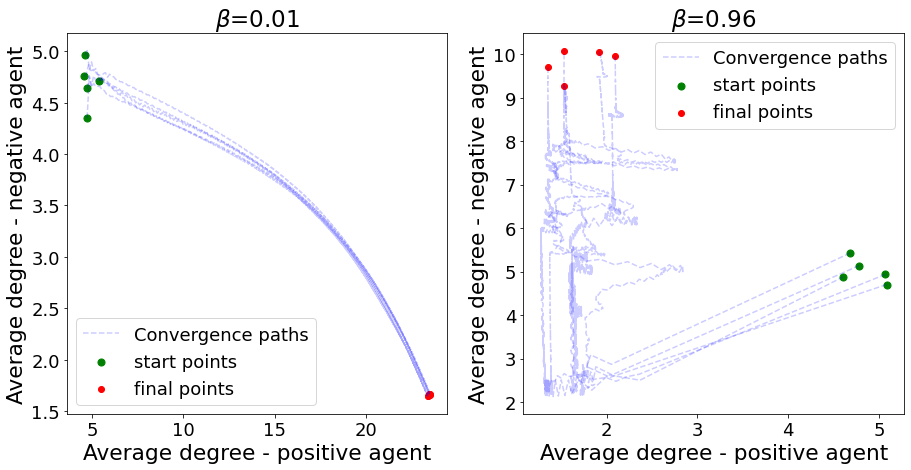

In [14]:
import matplotlib

n=1

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':(12,10),'axes.labelsize': 'large',
                           'axes.titlesize':20})
s=23
fig,ax=plt.subplots(figsize=(15,7),ncols=2)

for idx,run in enumerate(X[0]):
    
    ax[0].plot(run[::n],Y[0][idx][::n],label='Convergence paths',c='blue',linestyle='dashed',alpha=0.2)
    ax[0].set_xlabel('Average degree - positive agent')
    ax[0].set_ylabel('Average degree - negative agent')
    ax[0].scatter(run[0],Y[0][idx][0],c='green',label='start points',s=50)
    ax[0].scatter(run[-1],Y[0][idx][-1],c='red',label='final points')

    hand, labl = ax[0].get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax[0].legend(handout, lablout,loc='best')
    ax[0].set_title(r'$\beta$={}'.format(np.round(beta_crit/10.0,3)),fontsize=s)

for idx,run in enumerate(X[1]):
    
    ax[1].plot(run[::n],Y[1][idx][::n],label='Convergence paths',c='blue',linestyle='dashed',alpha=0.2)
    ax[1].set_xlabel('Average degree - positive agent')
    ax[1].set_ylabel('Average degree - negative agent')
    ax[1].scatter(run[0],Y[1][idx][0],c='green',label='start points',s=50)
    ax[1].scatter(run[-1],Y[1][idx][-1],c='red',label='final points')

    hand, labl = ax[1].get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax[1].legend(handout, lablout,loc='best')
    ax[1].set_title(r'$\beta$={}'.format(np.round(beta_crit*10.0,2)),fontsize=s)



In [5]:
X_dic = dict.fromkeys([0,1],None)
std_dic= dict.fromkeys([0,1],None)


In [72]:
budget_pos=40
budget_neg=40
beta=beta_crit/10.0
b = np.zeros(len(G.nodes.keys()))
iters=20


iim_iter=10000


X = np.full((iters,iim_iter+1,2),np.nan)
X_for_plot = []
for i in range(iters):
    print('iteration ',i)
    system = stack.mf_ising_system(G,b,iim_iter=iim_iter,iim_tol_fac=1e-8)
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta)
    controlArr = np.array(system.mag_history)
    X_for_plot.append(controlArr[-1])
    for j in range(controlArr.shape[0]):
        X[i,j,0]=sum(x>0 for x in controlArr[j])/len(controlArr[j])
        X[i,j,1]=sum(x<0 for x in controlArr[j])/len(controlArr[j])




X_new = np.nanmean(X,axis=0)
x_std = np.nanstd(X,axis=0,ddof=1)

if beta==beta_crit/10.0:
    X_dic[0]=X_new
    std_dic[0]=x_std
if beta==beta_crit*10.0:
    X_dic[1]=X_new
    std_dic[1]=x_std


  0%|          | 7/10000 [00:00<02:36, 63.75it/s]

iteration  0


  0%|          | 8/10000 [00:00<02:11, 76.23it/s]

iteration  1


  0%|          | 16/10000 [00:00<02:09, 76.98it/s]

iteration  2


  0%|          | 18/10000 [00:00<02:06, 78.87it/s]

iteration  3


  0%|          | 9/10000 [00:00<02:01, 81.94it/s]

iteration  4


  0%|          | 18/10000 [00:00<02:08, 77.92it/s]

iteration  5


  0%|          | 8/10000 [00:00<02:05, 79.79it/s]

iteration  6


  0%|          | 16/10000 [00:00<02:11, 76.21it/s]

iteration  7


  0%|          | 8/10000 [00:00<02:09, 77.29it/s]

iteration  8


  0%|          | 8/10000 [00:00<02:16, 73.14it/s]

iteration  9


  0%|          | 8/10000 [00:00<02:13, 74.99it/s]

iteration  10


  0%|          | 9/10000 [00:00<01:59, 83.51it/s]

iteration  11


  0%|          | 9/10000 [00:00<02:02, 81.32it/s]

iteration  12


  0%|          | 18/10000 [00:00<02:07, 78.49it/s]

iteration  13


  0%|          | 8/10000 [00:00<02:05, 79.60it/s]

iteration  14


  0%|          | 8/10000 [00:00<02:15, 73.81it/s]

iteration  15


  0%|          | 9/10000 [00:00<02:05, 79.89it/s]

iteration  16


  0%|          | 9/10000 [00:00<01:59, 83.87it/s]

iteration  17


  0%|          | 8/10000 [00:00<02:06, 78.73it/s]

iteration  18


  0%|          | 8/10000 [00:00<02:15, 73.98it/s]

iteration  19


 74%|███████▎  | 7350/10000 [01:35<00:34, 76.94it/s]
<ipython-input-72-fe9f6d0c862c>:26: RuntimeWarning: Mean of empty slice
  X_new = np.nanmean(X,axis=0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, '$\\beta$=0.96')

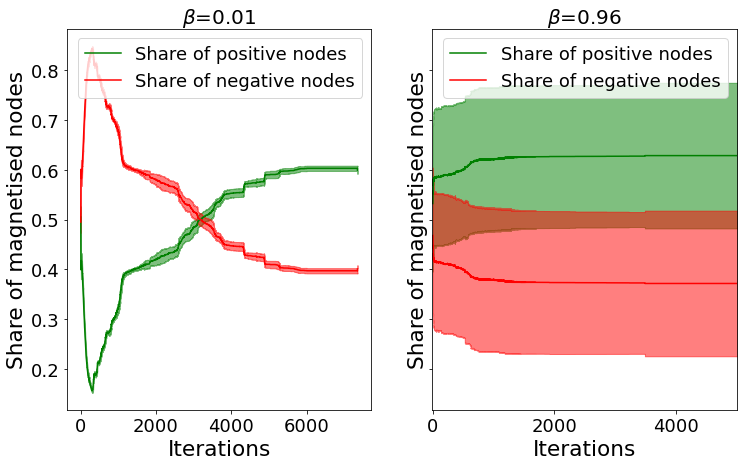

In [75]:
import matplotlib
s=20
matplotlib.rcParams.update({'font.size': 18,'figure.figsize':(12,7),'axes.labelsize': 'large',
                           'axes.titlesize':20})
fig,ax=plt.subplots(ncols=2,sharex=False,sharey=True)


X_new=X_dic[0] 
x_std = std_dic[0]

ax[0].plot(X_new[:,0],label='Share of positive nodes',c='green')

xrange= np.arange(0,iim_iter+1,1)

ax[0].fill_between(xrange,X_new[:,0]+x_std[:,0],X_new[:,0]-x_std[:,0],**{'color':'green','alpha':0.5})

ax[0].plot(X_new[:,1],label='Share of negative nodes',c='red')
ax[0].fill_between(xrange,X_new[:,1]+x_std[:,1],X_new[:,1]-x_std[:,1],**{'color':'red','alpha':0.5})

ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Share of magnetised nodes')
ax[0].legend()
ax[0].set_title(r'$\beta$={}'.format(np.round(beta_crit/10.0,2)),fontsize=s)


X_new=X_dic[1] 
x_std = std_dic[1]


ax[1].plot(X_new[:,0],label='Share of positive nodes',c='green')
ax[1].fill_between(xrange,X_new[:,0]+x_std[:,0],X_new[:,0]-x_std[:,0],**{'color':'green','alpha':0.5})

ax[1].plot(X_new[:,1],label='Share of negative nodes',c='red')
ax[1].fill_between(xrange,X_new[:,1]+x_std[:,1],X_new[:,1]-x_std[:,1],**{'color':'red','alpha':0.5})

ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Share of magnetised nodes')
ax[1].legend()
ax[1].set_xlim(-10,5000)
ax[1].set_title(r'$\beta$={}'.format(np.round(beta_crit*10.0,2)),fontsize=s)


In [38]:
# create a plot with nodes coloured according to magnetisation they have - green: positive, red:negative


final_mag = np.mean(np.array(X_for_plot),axis=) # final magnetisation array

magn_dic = {key: value for (key, value) in enumerate(final_mag)}


nx.set_node_attributes(G,magn_dic, "magnetisation")

groups=[]
for i in G.nodes():
    groups.append('Positive' if G.nodes[i]['magnetisation'] >=0.0 else 'Negative')
    
groups_dic = {key: value for (key, value) in enumerate(groups)}
nx.set_node_attributes(G,groups_dic, "group")




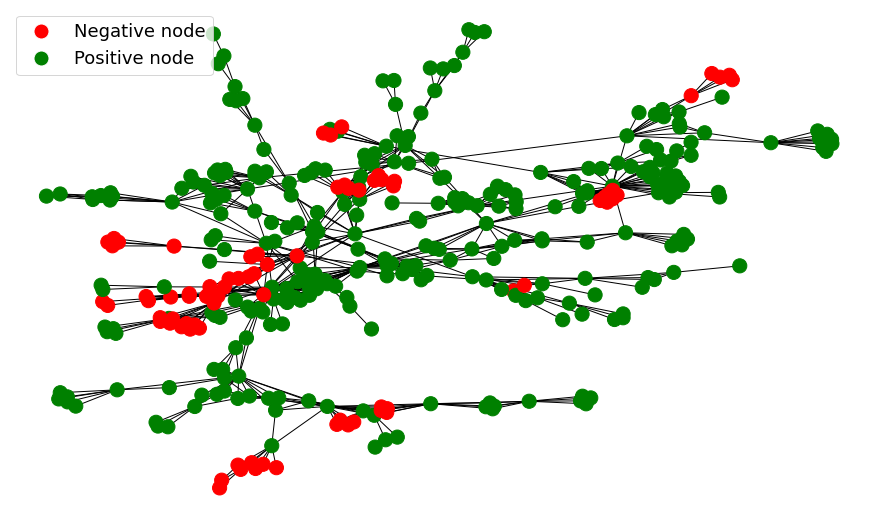

In [39]:
from matplotlib.lines import Line2D


color_state_map = {'Positive': 'green', 'Negative': 'red'}
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'group') 

nx.draw(G, pos=pos,
        with_labels=False,
        labels=labels, 
        node_color=[color_state_map[G.nodes[node]['group']] 
                    for node in G.nodes()], 
        node_size=200,
       font_color='white')

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o',color='w',markerfacecolor='r',markersize=15, label='Negative node'),
                   Line2D([0], [0], marker='o', color='w', label='Positive node',
                          markerfacecolor='g', markersize=15)]

plt.legend(handles=legend_elements)



In [ ]:
budget_pos=40.0
b = np.zeros(len(G.nodes.keys()))

budget_neg=40.0


beta_min = 0.5*beta_crit 
beta_max = 3*beta_crit 

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=5,endpoint=True,base=10)


control_history=np.zeros((len(beta_list),2))



for i,beta in enumerate(beta_list):
    
    system = stack.mf_ising_system(G,b,iim_iter=5000,iim_tol_fac=1e-3)
    control_pos,control_neg,final_mag=system.MF_IIM(budget_pos,budget_neg,beta)
    control_history[i]=np.array([hf.average_degree(system,control_pos,budget_pos),hf.average_degree(system,control_neg,budget_neg)])

     
    if i%1==0:
        print(i,beta)

print('FINISHED')       

In [ ]:
import matplotlib


matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(12,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


fig,ax = plt.subplots(ncols=1)

ax.plot(beta_list,control_history[:,0],c='green',label='Positive agent',linestyle='dashed',linewidth=3)
ax.plot(beta_list,control_history[:,1],c='red',label='Negative agent',linestyle='dashed',linewidth=3)

ax.set_xscale(value='log')

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree of targeted nodes')
ax.vlines(beta_crit,ymin=0,ymax=40,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax.set_xlabel(r'Interaction Strenght $\beta$')
ax.legend()
